In [3]:
#!pip install pyPhenology
# !pip install -U scikit-learn
# !pip install merf

In [2]:
import springtime
from springtime.datasets.daymet import DaymetSinglePoint, DaymetMultiplePoints

Creating folder /tmp/data


In [3]:
from pyPhenology import models, utils
import numpy as np

observations, predictors = utils.load_test_data(name='vaccinium', phenophase='flowers')


In [4]:
print(observations.shape)
observations.head()

(48, 5)


,species,site_id,year,doy,phenophase
48,vaccinium corymbosum,1,1998,122,501
49,vaccinium corymbosum,1,1998,122,501
50,vaccinium corymbosum,1,1991,124,501
51,vaccinium corymbosum,1,1991,124,501
52,vaccinium corymbosum,1,1998,126,501


In [5]:
print(observations["doy"].min())
print(observations["doy"].max())
print(observations["year"].min())
print(observations["year"].max())

122
144
1990
2001


In [6]:
print(predictors.shape)
predictors.head()

(4356, 7)


,site_id,temperature,year,doy,latitude,longitude,daylength
0,1,13.10,1990,-65,42.5429,-72.2011,10.24
1,1,13.26,1990,-64,42.5429,-72.2011,10.20
2,1,12.30,1990,-63,42.5429,-72.2011,10.16
3,1,12.15,1990,-62,42.5429,-72.2011,10.11
4,1,13.00,1990,-61,42.5429,-72.2011,10.07


In [7]:
print(predictors["doy"].min())
print(predictors["doy"].max())
print(predictors["year"].min())
print(predictors["year"].max())

-65
297
1990
2001


In [8]:
predictors.tail()

,site_id,temperature,year,doy,latitude,longitude,daylength
4351,1,7.93,2001,293,42.5429,-72.2011,10.55
4352,1,10.76,2001,294,42.5429,-72.2011,10.51
4353,1,8.45,2001,295,42.5429,-72.2011,10.46
4354,1,9.43,2001,296,42.5429,-72.2011,10.42
4355,1,18.26,2001,297,42.5429,-72.2011,10.37


The observations data.frame contains the direct phenology observations as well as an associated site and year for each. The predictors data.frame has several variables used to predict phenology, such as daily mean temperature, latitude and longitude, and daylength. They are listed for each site and year represented in observations.

In [9]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import folium
from shapely import wkt

In [10]:
df = pd.read_csv("combined_DBF.csv")
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, crs='epsg:4326')
df.head()

,Unnamed: 0,site_id,elevation_in_meters,state,species_id,genus,species,common_name,kingdom,individual_id,...,first_yes_doy,first_yes_julian_date,numdays_since_prior_no,last_yes_year,last_yes_month,last_yes_day,last_yes_doy,last_yes_julian_date,numdays_until_next_no,geometry
0,1,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4094,...,144,2454245,-9999,2007,5,24,144,2454245,-9999,POINT (-116.97386 45.56820)
1,2,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4100,...,151,2454252,-9999,2007,6,7,158,2454259,-9999,POINT (-116.97386 45.56820)
2,3,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4101,...,144,2454245,-9999,2007,6,21,172,2454273,-9999,POINT (-116.97386 45.56820)
3,1,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4094,...,136,2454602,-9999,2008,6,19,171,2454637,-9999,POINT (-116.97386 45.56820)
4,2,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4100,...,136,2454602,-9999,2008,6,12,164,2454630,35,POINT (-116.97386 45.56820)


In [11]:
print("We have",df.shape[0], "observations")
print("The observations are from",df['last_yes_year'].min(),"to",df['last_yes_year'].max())

We have 5059 observations
The observations are from 2007 to 2017


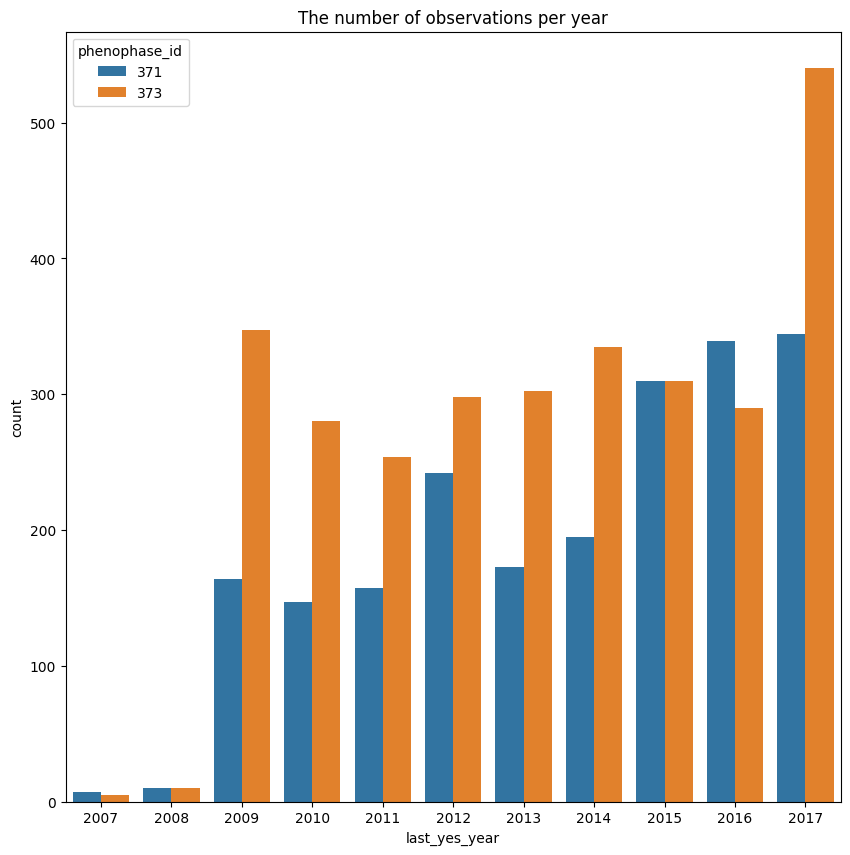

In [12]:
fig, ax= plt.subplots(1,1)  
fig.set_size_inches(10, 10)
plot_ = sns.countplot(x = 'last_yes_year', hue ='phenophase_id', data= df)
# for ind, label in enumerate(plot_.get_xticklabels()):
#     if ind % 5 == 0:  # every 5th label is kept
#         label.set_visible(True)
#     else:
#         label.set_visible(False)
# plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.title("The number of observations per year")
plt.show()

<Axes: >

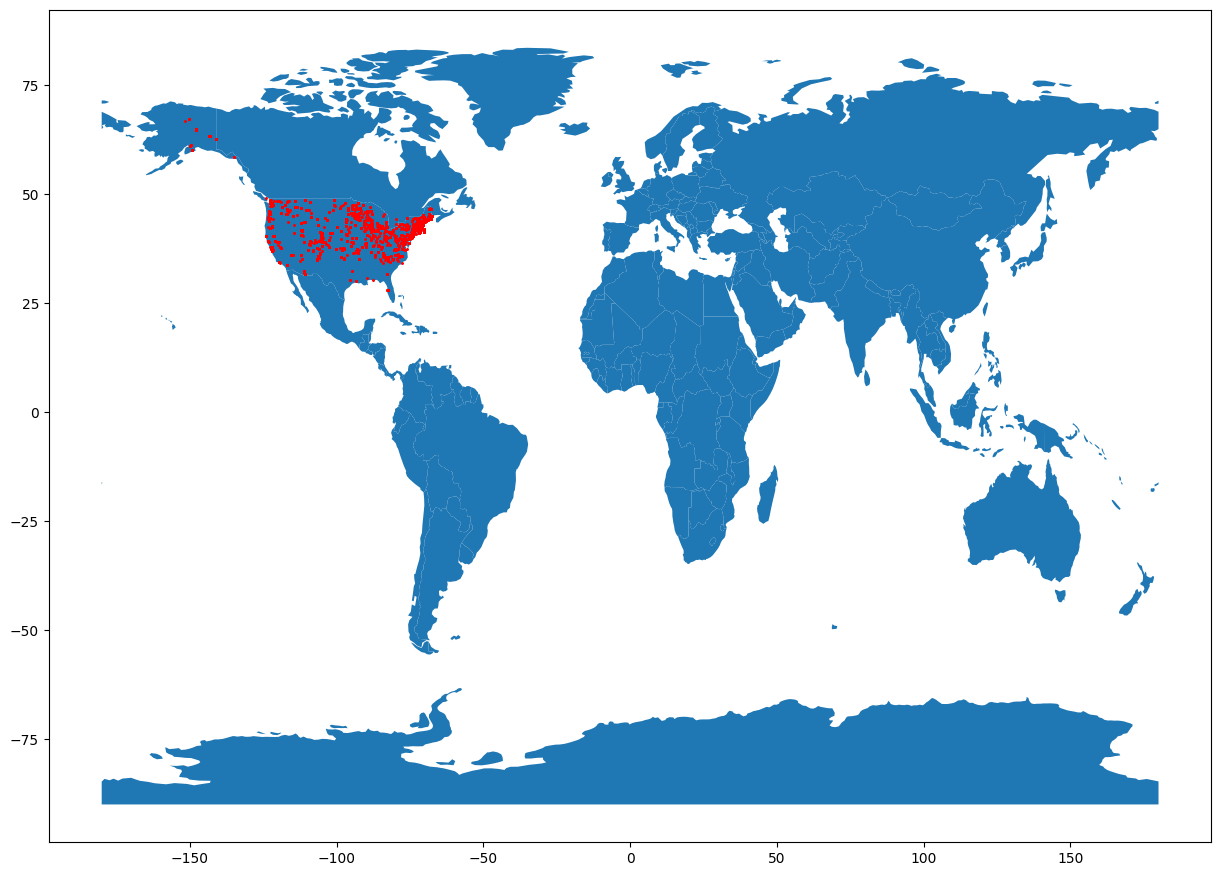

In [13]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df.plot(ax=world.plot(figsize=(15, 15)), marker='.', color='red', markersize=5)

In [14]:
df['lat'] = df.geometry.apply(lambda p: p.y)
df['lon'] = df.geometry.apply(lambda p: p.x)
df

,Unnamed: 0,site_id,elevation_in_meters,state,species_id,genus,species,common_name,kingdom,individual_id,...,numdays_since_prior_no,last_yes_year,last_yes_month,last_yes_day,last_yes_doy,last_yes_julian_date,numdays_until_next_no,geometry,lat,lon
0,1,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4094,...,-9999,2007,5,24,144,2454245,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862
1,2,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4100,...,-9999,2007,6,7,158,2454259,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862
2,3,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4101,...,-9999,2007,6,21,172,2454273,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862
3,1,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4094,...,-9999,2008,6,19,171,2454637,-9999,POINT (-116.97386 45.56820),45.568195,-116.973862
4,2,5533,1382,OR,92,Symphoricarpos,albus,common snowberry,Plantae,4100,...,-9999,2008,6,12,164,2454630,35,POINT (-116.97386 45.56820),45.568195,-116.973862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,296,27639,145,NH,36,Syringa,vulgaris,common lilac,Plantae,143257,...,85,2017,12,7,341,2458095,-9999,POINT (-72.26594 42.92350),42.923504,-72.265938
5055,297,27659,246,MN,36,Syringa,vulgaris,common lilac,Plantae,143328,...,11,2017,11,30,334,2458088,-9999,POINT (-93.20499 44.92120),44.921204,-93.204987
5056,298,27659,246,MN,36,Syringa,vulgaris,common lilac,Plantae,143340,...,11,2017,11,30,334,2458088,-9999,POINT (-93.20499 44.92120),44.921204,-93.204987
5057,299,27659,246,MN,36,Syringa,vulgaris,common lilac,Plantae,143341,...,11,2017,11,30,334,2458088,-9999,POINT (-93.20499 44.92120),44.921204,-93.204987


In [15]:
list(df)

['Unnamed: 0',
 'site_id',
 'elevation_in_meters',
 'state',
 'species_id',
 'genus',
 'species',
 'common_name',
 'kingdom',
 'individual_id',
 'phenophase_id',
 'phenophase_description',
 'first_yes_year',
 'first_yes_month',
 'first_yes_day',
 'first_yes_doy',
 'first_yes_julian_date',
 'numdays_since_prior_no',
 'last_yes_year',
 'last_yes_month',
 'last_yes_day',
 'last_yes_doy',
 'last_yes_julian_date',
 'numdays_until_next_no',
 'geometry',
 'lat',
 'lon']

In [16]:
df1 = df.groupby(["site_id","lat","lon","first_yes_year"], as_index=False)["first_yes_doy"].mean()
df1

,site_id,lat,lon,first_yes_year,first_yes_doy
0,2,43.085350,-70.691330,2009,113.285714
1,2,43.085350,-70.691330,2010,100.500000
2,2,43.085350,-70.691330,2011,110.666667
3,2,43.085350,-70.691330,2012,90.000000
4,2,43.085350,-70.691330,2013,112.833333
...,...,...,...,...,...
2345,35914,45.504875,-89.585678,2016,131.857143
2346,35914,45.504875,-89.585678,2017,132.606061
2347,35924,46.231968,-89.542152,2015,126.500000
2348,35924,46.231968,-89.542152,2016,122.545455


In [17]:
df1 = df1.rename(columns={"first_yes_year": "year", "first_yes_doy": "doy"})
df1 = df1.head(10)
df1

,site_id,lat,lon,year,doy
0,2,43.085350,-70.691330,2009,113.285714
1,2,43.085350,-70.691330,2010,100.500000
2,2,43.085350,-70.691330,2011,110.666667
3,2,43.085350,-70.691330,2012,90.000000
4,2,43.085350,-70.691330,2013,112.833333
5,2,43.085350,-70.691330,2014,121.000000
6,2,43.085350,-70.691330,2015,121.000000
7,2,43.085350,-70.691330,2016,114.833333
8,2,43.085350,-70.691330,2017,110.000000
9,3,35.879211,-84.172203,2011,62.000000


In [18]:
# # remove outliers from observations
# print(observations.shape)
# observations = observations[observations.doy < 181]
# print(observations.shape)


In [19]:
# we need the site_id too. So maybe better zip(df1.site_id,df1.lon, df1.lat)
dataset = DaymetMultiplePoints(points=list(zip(df1.lon, df1.lat)), years=[2007, 2017])
dataset

DaymetMultiplePoints(dataset='daymet_multiple_points', points=[(-70.69133, 43.08535), (-70.69133, 43.08535), (-70.69133, 43.08535), (-70.69133, 43.08535), (-70.69133, 43.08535), (-70.69133, 43.08535), (-70.69133, 43.08535), (-70.69133, 43.08535), (-70.69133, 43.08535), (-84.172203, 35.879211)], years=(2007, 2017))

In [20]:
dataset.download()
tempdata = dataset.load()
tempdata


R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-70.69133_43.08535",
+             lat = 43.08535,
+             lon = -70.69133,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+             internal = FA


Done !



>         
> 

R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-84.172203_35.879211",
+             lat = 35.879211,
+             lon = -84.172203,
+             start = 2007,
+             end =  2017,
+             path="/tmp/data",
+        


Done !



>         
> 


,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),x,y,geometry
0,2007,1,31955.08,14.77,183.73,68.34,6.49,-7.93,336.30,-70.691330,43.085350,POINT (-70.69133 43.08535)
1,2007,2,32001.91,0.00,90.38,64.98,5.63,1.98,704.60,-70.691330,43.085350,POINT (-70.69133 43.08535)
2,2007,3,32052.56,0.00,238.08,63.78,10.36,-3.13,484.89,-70.691330,43.085350,POINT (-70.69133 43.08535)
3,2007,4,32106.99,0.00,213.92,61.48,10.06,-0.52,588.05,-70.691330,43.085350,POINT (-70.69133 43.08535)
4,2007,5,32165.17,0.67,219.51,57.35,15.53,3.84,803.73,-70.691330,43.085350,POINT (-70.69133 43.08535)
...,...,...,...,...,...,...,...,...,...,...,...,...
4010,2017,361,34477.65,0.00,223.18,0.00,3.99,-5.06,419.28,-84.172203,35.879211,POINT (-84.17220 35.87921)
4011,2017,362,34497.92,0.00,258.93,0.00,3.50,-7.64,343.97,-84.172203,35.879211,POINT (-84.17220 35.87921)
4012,2017,363,34521.14,0.00,265.09,0.00,6.24,-5.33,410.97,-84.172203,35.879211,POINT (-84.17220 35.87921)
4013,2017,364,34547.32,0.00,191.32,0.00,3.76,-3.21,482.05,-84.172203,35.879211,POINT (-84.17220 35.87921)


In [21]:
# we need temperature
tempdata['temperature'] = (tempdata['tmax (deg c)'] + tempdata['tmin (deg c)'])/2
tempdata.head()

,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),x,y,geometry,temperature
0,2007,1,31955.08,14.77,183.73,68.34,6.49,-7.93,336.30,-70.69133,43.08535,POINT (-70.69133 43.08535),-0.720
1,2007,2,32001.91,0.00,90.38,64.98,5.63,1.98,704.60,-70.69133,43.08535,POINT (-70.69133 43.08535),3.805
2,2007,3,32052.56,0.00,238.08,63.78,10.36,-3.13,484.89,-70.69133,43.08535,POINT (-70.69133 43.08535),3.615
3,2007,4,32106.99,0.00,213.92,61.48,10.06,-0.52,588.05,-70.69133,43.08535,POINT (-70.69133 43.08535),4.770
4,2007,5,32165.17,0.67,219.51,57.35,15.53,3.84,803.73,-70.69133,43.08535,POINT (-70.69133 43.08535),9.685


In [22]:
# we need site id
# This function is a toy -- needs to search for the right site_id
def site_id(lat, lon):
    num = 2
    return num

tempdata['site_id'] = np.vectorize(site_id)(tempdata['y'], tempdata['x'])

In [23]:
tempdata

,year,yday,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),x,y,geometry,temperature,site_id
0,2007,1,31955.08,14.77,183.73,68.34,6.49,-7.93,336.30,-70.691330,43.085350,POINT (-70.69133 43.08535),-0.720,2
1,2007,2,32001.91,0.00,90.38,64.98,5.63,1.98,704.60,-70.691330,43.085350,POINT (-70.69133 43.08535),3.805,2
2,2007,3,32052.56,0.00,238.08,63.78,10.36,-3.13,484.89,-70.691330,43.085350,POINT (-70.69133 43.08535),3.615,2
3,2007,4,32106.99,0.00,213.92,61.48,10.06,-0.52,588.05,-70.691330,43.085350,POINT (-70.69133 43.08535),4.770,2
4,2007,5,32165.17,0.67,219.51,57.35,15.53,3.84,803.73,-70.691330,43.085350,POINT (-70.69133 43.08535),9.685,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4010,2017,361,34477.65,0.00,223.18,0.00,3.99,-5.06,419.28,-84.172203,35.879211,POINT (-84.17220 35.87921),-0.535,2
4011,2017,362,34497.92,0.00,258.93,0.00,3.50,-7.64,343.97,-84.172203,35.879211,POINT (-84.17220 35.87921),-2.070,2
4012,2017,363,34521.14,0.00,265.09,0.00,6.24,-5.33,410.97,-84.172203,35.879211,POINT (-84.17220 35.87921),0.455,2
4013,2017,364,34547.32,0.00,191.32,0.00,3.76,-3.21,482.05,-84.172203,35.879211,POINT (-84.17220 35.87921),0.275,2


In [24]:
# We need doy column
tempdata = tempdata.rename(columns={'yday': 'doy'})


In [25]:
model = models.ThermalTime()

In [26]:
model.fit(df1, tempdata)

/home/jovyan/mambaforge-pypy3/envs/springtime/lib/python3.9/site-packages/pyPhenology/models/utils/misc.py:81: UserWarning: Dropped 1 of 10 observations because of missing data
 Missing data from: 
   site_id  year
9        3  2011
  warn('Dropped {n0} of {n1} observations because of missing data'.format(n0=n_dropped, n1=original_sample_size) +


In [27]:
model.get_params()

{'t1': 71.30609332237756, 'T': -8.574720793980923, 'F': 215.16417948773926}

In [28]:
model.predict()

array([113,  98, 112,  95, 114, 119, 120, 110, 114])

In [29]:
model.score()

2.959572654081088

In [30]:
df1

,site_id,lat,lon,year,doy
0,2,43.085350,-70.691330,2009,113.285714
1,2,43.085350,-70.691330,2010,100.500000
2,2,43.085350,-70.691330,2011,110.666667
3,2,43.085350,-70.691330,2012,90.000000
4,2,43.085350,-70.691330,2013,112.833333
5,2,43.085350,-70.691330,2014,121.000000
6,2,43.085350,-70.691330,2015,121.000000
7,2,43.085350,-70.691330,2016,114.833333
8,2,43.085350,-70.691330,2017,110.000000
9,3,35.879211,-84.172203,2011,62.000000


In [31]:
dataset = DaymetSinglePoint(point=(df1.iloc[0]["lon"],df1.iloc[0]["lat"]), years=[df1.iloc[0]["year"], df1.iloc[0]["year"]])
dataset.download()
tempdata_i = dataset.load()
fea_mat = tempdata_i[["prcp (mm/day)","srad (W/m^2)", "swe (kg/m^2)", "tmax (deg c)", 
                  "tmin (deg c)", "vp (Pa)" ]].to_numpy().flatten()
for i in range(1, len(df1)):
    dataset = DaymetSinglePoint(point=(df1.iloc[i]["lon"],df1.iloc[i]["lat"]), years=[df1.iloc[i]["year"], df1.iloc[i]["year"]])
    dataset.download()
    tempdata_i = dataset.load()
    tempdata_i
    fea_v = tempdata_i[["prcp (mm/day)","srad (W/m^2)", "swe (kg/m^2)", "tmax (deg c)", 
                      "tmin (deg c)", "vp (Pa)" ]].to_numpy().flatten()
    fea_mat = np.vstack((fea_mat, fea_v))

fea_mat.shape


R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-70.69133_43.08535",
+             lat = 43.08535,
+             lon = -70.69133,
+             start = 2009,
+             end =  2009,
+             path="/tmp/data",
+             internal = FA


Done !



>         
> 

R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-70.69133_43.08535",
+             lat = 43.08535,
+             lon = -70.69133,
+             start = 2010,
+             end =  2010,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-70.69133_43.08535",
+             lat = 43.08535,
+             lon = -70.69133,
+             start = 2011,
+             end =  2011,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-70.69133_43.08535",
+             lat = 43.08535,
+             lon = -70.69133,
+             start = 2012,
+             end =  2012,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-70.69133_43.08535",
+             lat = 43.08535,
+             lon = -70.69133,
+             start = 2013,
+             end =  2013,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-70.69133_43.08535",
+             lat = 43.08535,
+             lon = -70.69133,
+             start = 2014,
+             end =  2014,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-70.69133_43.08535",
+             lat = 43.08535,
+             lon = -70.69133,
+             start = 2015,
+             end =  2015,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-70.69133_43.08535",
+             lat = 43.08535,
+             lon = -70.69133,
+             start = 2016,
+             end =  2016,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-70.69133_43.08535",
+             lat = 43.08535,
+             lon = -70.69133,
+             start = 2017,
+             end =  2017,
+             path="/tmp/data",
+            


Done !



>         
> 

R version 4.2.1 (2022-06-23) -- "Funny-Looking Kid"
Copyright (C) 2022 The R Foundation for Statistical Computing
Platform: aarch64-unknown-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

>         library(daymetr)
>         daymetr::download_daymet(
+             site = "daymet_single_point_-84.172203_35.879211",
+             lat = 35.879211,
+             lon = -84.172203,
+             start = 2011,
+             end =  2011,
+             path="/tmp/data",
+        

>         
> 


Done !



(10, 2190)

In [32]:
df_fea = pd.DataFrame(fea_mat)
data = pd.concat([df1, df_fea], axis=1)
data

,site_id,lat,lon,year,doy,0,1,2,3,4,...,2180,2181,2182,2183,2184,2185,2186,2187,2188,2189
0,2,43.085350,-70.691330,2009,113.285714,0.00,209.64,21.55,-4.67,-16.28,...,18.29,-3.77,-14.43,199.94,3.27,151.63,21.55,-0.67,-10.60,272.55
1,2,43.085350,-70.691330,2010,100.500000,4.93,107.12,17.68,0.59,-5.71,...,17.80,6.45,-10.36,277.94,0.00,244.18,17.80,10.29,-6.96,362.56
2,2,43.085350,-70.691330,2011,110.666667,0.00,216.63,1.94,10.47,-2.75,...,3.71,3.16,-7.52,347.29,2.07,99.18,3.31,1.05,-5.05,419.70
3,2,43.085350,-70.691330,2012,90.000000,3.36,135.83,58.59,5.66,-2.36,...,60.29,1.36,-5.68,399.91,0.00,122.28,60.12,-0.93,-5.59,402.77
4,2,43.085350,-70.691330,2013,112.833333,0.00,165.01,41.50,1.09,-6.56,...,41.50,4.19,-2.84,495.46,0.00,243.40,41.50,-0.65,-14.29,202.29
5,2,43.085350,-70.691330,2014,121.000000,4.03,139.63,61.71,-5.92,-14.19,...,57.67,1.92,-8.60,319.33,0.00,232.55,57.67,-2.55,-12.51,233.93
6,2,43.085350,-70.691330,2015,121.000000,0.00,188.63,18.86,-1.93,-11.96,...,19.01,0.48,-6.78,367.74,0.00,198.35,18.86,3.39,-5.65,401.07
7,2,43.085350,-70.691330,2016,114.833333,0.00,139.85,20.69,5.24,-0.55,...,24.33,4.79,-3.82,460.43,0.00,151.58,22.98,4.25,-2.79,497.25
8,2,43.085350,-70.691330,2017,110.000000,0.00,231.01,29.60,4.52,-7.72,...,29.60,-12.97,-22.29,102.21,0.00,217.52,29.60,-11.07,-21.17,112.78
9,3,35.879211,-84.172203,2011,62.000000,40.52,156.36,0.00,14.48,6.35,...,0.00,14.79,0.72,643.44,0.00,253.64,0.00,14.79,2.74,743.66


In [34]:
# Train-test split
# RF
# merf
# ebm

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
# how pyphenology stat methods work?